In [352]:
## Packages
# system
import os
import math
# data wrangling
import numpy as np
import pandas as pd
from scipy import stats
from dfply import *
import statistics
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score
## Settings
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', 1000)

## Data Import

In [284]:
df = pd.read_csv('../processed_data/provider_final_new.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('Provider')
display(df.shape)
df.head(3)

(5410, 46)

,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,No,4.0,5.00000,0.0,0.550000,Both,6.0,5.760000,5.0,79.0,77.880000,5.0,19.0,1.0,1.0,1.0,4185.600000,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,11.0,0.550000,yes,50.0,yes,422.0,yes,278.0,yes,1.44,24,25,1.04,109980,4582.50,0,2,23,1.09
PRV51003,Yes,4.0,5.16129,0.0,2.357143,Both,7.0,6.674242,6.0,71.0,69.083333,53.0,66.0,3.0,3.0,1.0,4588.409091,25.0,1.0,0.016129,yes,2.0,yes,2.0,yes,2.0,yes,25.0,0.357143,yes,52.0,yes,1351.0,yes,372.0,yes,3.67,117,132,1.13,671956,5743.21,0,4,93,1.19
PRV51004,No,0.0,0.00000,0.0,1.429530,OP,7.0,6.812081,8.0,72.0,71.261745,0.0,138.0,0.0,9.0,1.0,350.134228,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,72.0,0.483221,yes,52.0,yes,3006.0,yes,375.0,yes,1.43,138,149,1.08,52480,380.29,0,12,149,1.27


## Exclude columns

In [111]:
# display(df.columns[df.columns.str.contains('DupClaim')])
# del_col = ['DupClaim_IP','DupClaim_OP','DupClaimRatio_IP','DupClaimRatio_OP',
#            'DupClaimMultiState_IP','DupClaimMultiState_OP','DupClaimMultiProvider_IP','DupClaimMultiProvider_OP',
#           'DupClaimMultiStartDt_IP','DupClaimMultiStartDt_OP']

In [88]:
# print('before delete cols', df.shape)
# df_num = df.drop(del_col, axis=1)
# print('after delete cols', df_num.shape)

before delete cols (5410, 46)
after delete cols (5410, 36)


## dummy variables

In [285]:
# Make dummies
encode_cols = df[~df.applymap(np.isreal)].dropna(axis=1).columns.to_list()
print(encode_cols)
df[encode_cols[2:]] = df[encode_cols[2:]].applymap(lambda x: 1 if x.lower() == 'yes' else 0)
dummies = pd.get_dummies(df['Serves'],prefix='Serves_',drop_first=True)
df_dum = pd.concat([df.drop('Serves',axis=1),dummies],axis=1)
df_dum.shape

['PotentialFraud', 'Serves', 'DupClaim_IP', 'DupClaimMultiState_IP', 'DupClaimMultiProvider_IP', 'DupClaimMultiStartDt_IP', 'DupClaim_OP', 'DupClaimMultiState_OP', 'DupClaimMultiProvider_OP', 'DupClaimMultiStartDt_OP']


(5410, 47)

In [286]:
# this is for pos_label for precision & recall for gridsearchcv
df_dum['PotentialFraud'] = np.where(df_num_dum['PotentialFraud']=='Yes', 1, 0)
df_dum['PotentialFraud'] = np.where(df_num_dum['PotentialFraud']=='Yes', 1, 0)

In [181]:
# def make_dummy_df(df, cols) :
#     for x in cols:
#         dums = pd.get_dummies(df[x], drop_first=True, prefix=x)
#         df = pd.concat((df, dums), axis=1)
#         df.drop([x], axis=1, inplace=True)
#     return df

In [262]:
# # dummy_list_1 = ['Serves'] # for df_num
# dummy_list_2 = ['Serves','DupClaim_IP','DupClaim_OP','DupClaimRatio_IP','DupClaimRatio_OP',
#            'DupClaimMultiState_IP','DupClaimMultiState_OP','DupClaimMultiProvider_IP','DupClaimMultiProvider_OP',
#           'DupClaimMultiStartDt_IP','DupClaimMultiStartDt_OP'] # for df

In [251]:
# # df_num_dum = make_dummy_df(df_num, dummy_list_1)
# df_dum = make_dummy_df(df, dummy_list_2)
# display(df_dum.shape)
# foo = make_dummy_df(df, encode_cols)
# display(foo.shape)

(5410, 1598)

(5410, 47)

In [187]:
# display(df_dum.head(2))
# display(df_num_dum.head(2))

## split train-test

In [287]:
x = df_dum.drop(['PotentialFraud'], axis = 1)
y = df_dum.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)

In [288]:
# for flag 1,0
print('ytrain class ave', ytrain.mean())
print('ytest class ave', ytest.mean())

print(x.shape)
print(xtrain.shape)
print(xtest.shape)

ytrain class ave 0.09357670979667283
ytest class ave 0.0933456561922366
(5410, 46)
(4328, 46)
(1082, 46)


## Logistic Regression

In [356]:
# recall of positive - sensitivity; recall of negative - specificity
lr = LogisticRegression(random_state=4, class_weight='balanced') # create fake positive/negative to balance

# lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 'max_iter':[1000]}]
# lr_params = [{'penalty': ['elasticnet'], "C":[0.01, 0.1, 1,10,100],
#              'l1_ratio': [0,0.2,0.4,0.6, 0.8,1], 'solver': ['saga']}]

lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
              'max_iter':[1000], 'solver':['liblinear']}] # l1=lasso

lr_params = [{'penalty': ['l1'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
              'max_iter':[1000], 'solver':['liblinear']}, 
             {'penalty': ['l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
              'max_iter':[1000]}] # l1=lasso


kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)
scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), # average: use binary instead of weighted because already have class_weight = balanced in rf, also it's a binary, weighted is more about multiclass; for evaluation don't want to weighted based on proportion  
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), 
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(balanced_accuracy_score),
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'binary')}

# scores = ['f1_weighted', 'recall', 'precision', 'accuracy']
# lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
#                        cv = 5, verbose=2, scoring='recall', n_jobs=-1)

lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False, n_jobs=-1)

%time lr_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.0s


CPU times: user 688 ms, sys: 309 ms, total: 997 ms
Wall time: 7.44 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    7.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=4, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecat...
             scoring={'accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=weighted),
                      'precision': make_scorer(precision_score, pos_label=1, average=weighted),
                      'recall': make_scorer(

In [354]:
# best model
# display(lr_grid.best_params_)
# print('lr best validation score', lr_grid.best_score_)
# print('lr best train score', lr_grid.score(xtrain, ytrain))

In [357]:
keys = list(lr_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [358]:
lr_grid_scores = pd.DataFrame({'params': lr_grid.cv_results_['params'], 
              'mean_test_recall': lr_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': lr_grid.cv_results_['mean_train_recall'],
              'mean_test_f1': lr_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': lr_grid.cv_results_['mean_train_f1'],
              'mean_test_precision': lr_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': lr_grid.cv_results_['mean_train_precision'],
              'mean_test_accuracy': lr_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': lr_grid.cv_results_['mean_train_accuracy'],
              'mean_test_specificity': lr_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': lr_grid.cv_results_['mean_train_specificity'] 
             })
lr_grid_scores.to_csv('../output/lr_grid_scores.csv')
lr_grid_scores

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity
0,"{'C': 0.0001, 'max_iter': 1000, 'penalty': 'l1...",0.891639,0.892733,0.904752,0.905703,0.930638,0.931501,0.858300,0.861948,0.891639,0.892733
1,"{'C': 0.0001, 'max_iter': 1000, 'penalty': 'l2...",0.887250,0.889961,0.901462,0.903848,0.929675,0.932062,0.856986,0.866231,0.887250,0.889961
2,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l1'...",0.891869,0.892387,0.905049,0.905546,0.931354,0.931951,0.861749,0.864248,0.891869,0.892387
3,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'...",0.885863,0.889498,0.900356,0.903405,0.929056,0.931492,0.855114,0.864038,0.885863,0.889498
4,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l1',...",0.887019,0.888459,0.901889,0.903294,0.932656,0.934697,0.870144,0.878411,0.887019,0.888459
5,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...",0.887942,0.891058,0.902037,0.904742,0.930098,0.932620,0.858475,0.867943,0.887942,0.891058
6,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ...",0.889328,0.892618,0.904142,0.906981,0.935835,0.938525,0.882489,0.892606,0.889328,0.892618
7,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', ...",0.886556,0.889441,0.900936,0.903453,0.929496,0.931927,0.856603,0.865944,0.886556,0.889441
8,"{'C': 1, 'max_iter': 1000, 'penalty': 'l1', 's...",0.889327,0.893253,0.904087,0.907524,0.935616,0.939015,0.881381,0.894341,0.889327,0.893253
9,"{'C': 1, 'max_iter': 1000, 'penalty': 'l2', 's...",0.888175,0.889325,0.902257,0.903394,0.930372,0.932024,0.859710,0.866434,0.888175,0.889325


In [ ]:
# never split data into T/F and handle them differently
# L2 is more flexible because it is smooth function, L1 is not a smooth function
# elasticnet may keep need to use the solver that works for L1, because L2 is more flexbile
# preceision expected to be 90-95%
# can change the threshold of probabilty

In [216]:
lr = LogisticRegression(random_state=4, class_weight='balanced')
lr_params = [{'penalty': ['l1'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
              'max_iter':[1000], 'solver':['liblinear']}] # l1=lasso
lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
                       cv = 5, verbose=2, scoring='recall', refit=True, n_jobs=-1)
%time lr_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.6s finished


CPU times: user 777 ms, sys: 196 ms, total: 973 ms
Wall time: 9.18 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=4, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [1000], 'penalty': ['l1'],
                          'solver': ['liblinear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=2)

In [217]:
# confusion matrix
ypred = lr_grid.best_estimator_.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

recall = recall_score(ytrain.array, ypred, average='binary', pos_label=0) # sensitivity
print('recall:', round(recall, ndigits=5))
precision = lr_grid.best_estimator_.score(xtrain, ytrain) # precision
print('precision:', round(precision, ndigits=4))
accuracy = accuracy_score(ytrain.array, ypred) # accuracy
print('accuracy', round(accuracy, 4))

from sklearn.metrics import classification_report
classification_report(ytrain.array, ypred)

,0,1
0,3493,430
1,43,362


recall: 0.89039
precision: 0.8907
accuracy 0.8907


'              precision    recall  f1-score   support\n\n           0       0.99      0.89      0.94      3923\n           1       0.46      0.89      0.60       405\n\n    accuracy                           0.89      4328\n   macro avg       0.72      0.89      0.77      4328\nweighted avg       0.94      0.89      0.91      4328\n'

In [218]:
# yes is pos
print(367/(367+45))
# no is pos
print(3498/(3498+418))
print(3061/(3061+369))
print(3498/(3498+418))

0.8907766990291263
0.8932584269662921
0.8924198250728863
0.8932584269662921


## Random Forest

In [308]:
rf = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced')

In [490]:
print('num of observations', xtrain.shape[0])
print('num of features', xtrain.shape[1])
# print('min_samples_leaf', list(np.arange(2,11,2))) # more computationally expensive than min_split, but control
# print('max_depth', list(np.arange(1,36,11)))

max_features_1 = np.arange(2,int(xtrain.shape[1]/2),4)
print('max_features', max_features_1)
min_split_1 = np.arange(5,21,5)
print('min_samples_split', min_split_1) # use one, min_leaf & min_split are smiliar

num of observations 4328
num of features 46
max_features [ 2  6 10 14 18 22]
min_samples_split [ 5 10 15 20]


In [491]:
rf_params = [{'max_features': max_features_1,'n_estimators': [200, 500],
             'min_samples_split': min_split_1}]

kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), # use binary not weighted
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), # not use balanced_accurarcy_score
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')
         }


rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False)

%time rf_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_split=5, n_estimators=200 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   2.2s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   2.1s
[CV] max_features=2, min_samples_split=5, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=5, n_estimators=500, total=   2.4s
[CV] max_features=2, min_samples_split=5, n_estim

[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   3.1s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   4.2s
[CV] max_features=6, min_samples_split=10, n_estimators=500 ..........
[CV]  max_features=6, min_samples_split=10, n_estimators=500, total=   3.4s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.3s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.3s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.3s
[CV] max_features=6, min_samples_split=15, n_estimators=200 ..........
[CV]  max_features=6, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_split=15,

[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   1.9s
[CV] max_features=10, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=200, total=   1.7s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.3s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.5s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.4s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.7s
[CV] max_features=10, min_samples_split=20, n_estimators=500 .........
[CV]  max_features=10, min_samples_split=20, n_estimators=500, total=   4.3s
[CV] max_features=14, min_samples_s

[CV]  max_features=18, min_samples_split=5, n_estimators=500, total=   6.6s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   3.2s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.5s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.5s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.8s
[CV] max_features=18, min_samples_split=10, n_estimators=200 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=200, total=   2.6s
[CV] max_features=18, min_samples_split=10, n_estimators=500 .........
[CV]  max_features=18, min_samples_split=10, n_estimators=500, total=   6.3s
[CV] max_features=18, min_samples_sp

[CV]  max_features=22, min_samples_split=15, n_estimators=500, total=   7.3s
[CV] max_features=22, min_samples_split=15, n_estimators=500 .........
[CV]  max_features=22, min_samples_split=15, n_estimators=500, total=   7.2s
[CV] max_features=22, min_samples_split=15, n_estimators=500 .........
[CV]  max_features=22, min_samples_split=15, n_estimators=500, total=   7.5s
[CV] max_features=22, min_samples_split=15, n_estimators=500 .........
[CV]  max_features=22, min_samples_split=15, n_estimators=500, total=   8.1s
[CV] max_features=22, min_samples_split=15, n_estimators=500 .........
[CV]  max_features=22, min_samples_split=15, n_estimators=500, total=   7.7s
[CV] max_features=22, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=22, min_samples_split=20, n_estimators=200, total=   2.8s
[CV] max_features=22, min_samples_split=20, n_estimators=200 .........
[CV]  max_features=22, min_samples_split=20, n_estimators=200, total=   2.9s
[CV] max_features=22, min_samples_s

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 14.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=...
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(p

In [492]:
keys = list(rf_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [493]:
rf_grid_scores = pd.DataFrame({'params': rf_grid.cv_results_['params'], 
              'mean_test_recall': rf_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid.cv_results_['mean_train_recall'],
              'mean_test_f1': rf_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid.cv_results_['mean_train_f1'],
              'mean_test_precision': rf_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid.cv_results_['mean_train_precision'],
              'mean_test_accuracy': rf_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid.cv_results_['mean_train_accuracy'],
              'mean_test_specificity': rf_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid.cv_results_['mean_train_specificity'], 
              'mean_test_roc_auc_score': rf_grid.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid.cv_results_['mean_train_roc_auc_score']
             })
rf_grid_scores.to_csv('../output/rf_grid_scores.csv')
rf_grid_scores.iloc[:,1:]

,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity,mean_test_roc_auc_score,mean_train_roc_auc_score
0,0.543210,0.999383,0.611586,0.984495,0.702490,0.970047,0.935536,0.997054,0.976037,0.996814,0.759623,0.998098
1,0.538272,1.000000,0.611431,0.985403,0.710441,0.971229,0.935998,0.997227,0.977057,0.996941,0.757664,0.998471
2,0.651852,0.983951,0.640223,0.904405,0.629662,0.836803,0.931377,0.980534,0.960234,0.980181,0.806043,0.982066
3,0.646914,0.986420,0.632368,0.905648,0.618979,0.837125,0.929529,0.980765,0.958705,0.980181,0.802809,0.983300
4,0.713580,0.962346,0.638387,0.829940,0.577848,0.729583,0.924214,0.963089,0.945959,0.963166,0.829769,0.962756
5,0.723457,0.967284,0.639490,0.832280,0.573328,0.730442,0.923520,0.963493,0.944174,0.963102,0.833815,0.965193
6,0.735802,0.951235,0.620603,0.780720,0.536997,0.662102,0.915665,0.949977,0.934234,0.949847,0.835018,0.950541
7,0.738272,0.952469,0.624061,0.780526,0.540727,0.661237,0.916591,0.949862,0.934999,0.949592,0.836635,0.951031
8,0.511111,1.000000,0.592261,0.995395,0.705813,0.990837,0.934149,0.999134,0.977822,0.999044,0.744466,0.999522
9,0.520988,1.000000,0.604444,0.994782,0.723134,0.989621,0.936229,0.999018,0.979096,0.998917,0.750042,0.999458


In [535]:
best_row = rf_grid_scores.mean_test_recall.idxmax()
worst_row = rf_grid_scores.mean_test_recall.idxmin()
print('best RF row number', best_row)
print('worst RF row number', worst_row)
# print('best RF', rf_grid_scores.params[best_row], 'mean_test_recall', round(rf_grid_scores.mean_test_recall[best_row], 4))
print('best RF', rf_grid_scores.params[best_row], '\n',
      'mean_test_f1', round(rf_grid_scores.mean_test_f1[best_row], 4),
      'mean_test_recall', round(rf_grid_scores.mean_test_recall[best_row], 4),
     'mean_test_specificity', round(rf_grid_scores.mean_test_specificity[best_row], 4))
# print(rf_grid_scores.params[best_row+1], rf_grid_scores.mean_test_recall[best_row+1])
# print(rf_grid_scores.params[best_row-1], rf_grid_scores.mean_test_recall[best_row-1])
# print(rf_grid_scores.params[best_row+4], rf_grid_scores.mean_test_recall[best_row+4])

best RF row number 7
worst RF row number 8
best RF {'max_features': 2, 'min_samples_split': 20, 'n_estimators': 500} 
 mean_test_f1 0.6241 mean_test_recall 0.7383 mean_test_specificity 0.935


In [523]:
rf_best_1 = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced', 
                                  max_features=2, min_samples_split=20, n_estimators=500)
rf_best_1.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)

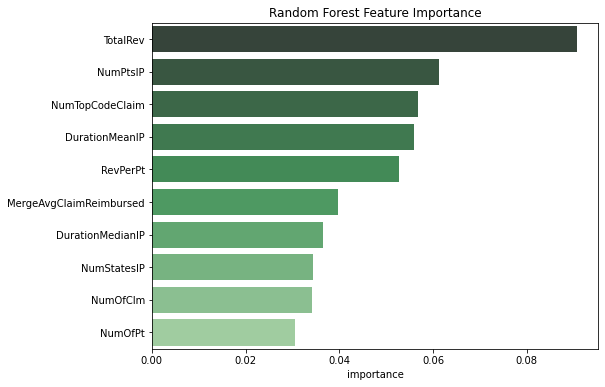

In [524]:
rf_feature_imp = pd.DataFrame(data = rf_best_1.feature_importances_, index=xtrain.columns, columns=['importance']).sort_values(by = 'importance', ascending=False)
# rf_feature_imp.plot(kind = 'bar')
rf_feature_imp.to_csv('../output/rf_final_features_importance.csv')
plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp.index[:10], x = 'importance', data = rf_feature_imp[:10],palette=sns.color_palette('Greens_d', n_colors=10))
plt.title('Random Forest Feature Importance')
plt.savefig('../output/rf_final_feature_importance.png')

In [503]:
rf_grid_scores_test = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('test')]]
display(rf_grid_scores_test.head(2))
rf_grid_scores_train = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('train')]]
display(rf_grid_scores_train.head(2))

,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
0,0.543210,0.611586,0.702490,0.935536,0.976037,0.759623
1,0.538272,0.611431,0.710441,0.935998,0.977057,0.757664


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.999383,0.984495,0.970047,0.997054,0.996814,0.998098
1,1.000000,0.985403,0.971229,0.997227,0.996941,0.998471


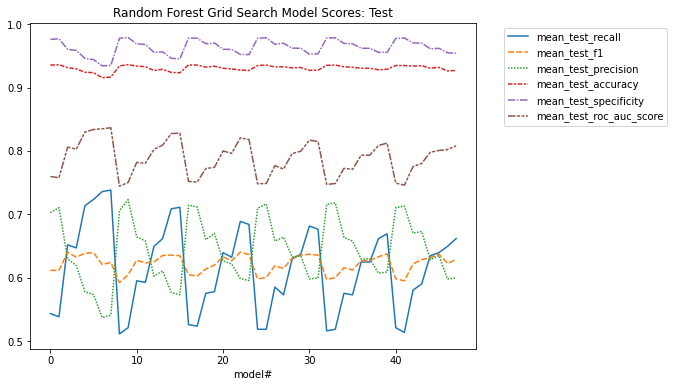

In [508]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_test)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.xlim(0,20)
# plt.xticks(np.arange(0,21,1))
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Test')
plt.savefig('../output/rf_gridsearch_scores_test4.png')
# plt.savefig('../output/rf_gridsearch_scores_test_full.png')

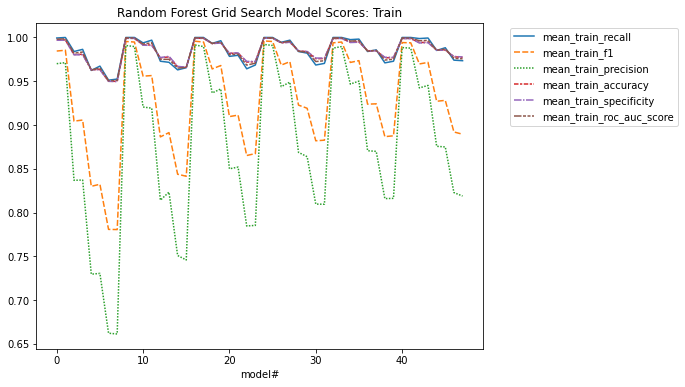

In [507]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_train)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Train')
plt.savefig('../output/rf_gridsearch_scores_train4.png')
# plt.savefig('../output/rf_gridsearch_scores_train_full.png')

In [511]:
# second try
# display(rf_grid.best_estimator_)
# print('RF best validation score', rf_grid.best_score_)
# print('RF best train score', rf_grid.score(xtrain, ytrain))

In [512]:
# first try
# display(rf_grid.best_estimator_)
# print('RF best validation score', rf_grid.best_score_)
# print('RF best train score', rf_grid.score(xtrain, ytrain))

#### finer gridsearch of random forest

In [519]:
max_features_2 = np.arange(1,5,1)
print('max_features', max_features_2)
# min_leaf = np.arange(2, 9, 1)
# display(min_leaf)
min_split_2 = np.arange(16, 25, 1)
print('min_split', min_split_2)

max_features [1 2 3 4]
min_split [16 17 18 19 20 21 22 23 24]


In [525]:
rf_params = [{'max_features': max_features_2,'n_estimators': [500,1000],
             'min_samples_split': min_split}] # 'min_samples_leaf': min_leaf,

kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'),
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), # use accuracy_score instead of balanced_accuracy_score
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'macro')
         }


rf_grid_fine = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False)

%time rf_grid_fine.fit(xtrain, ytrain)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] max_features=1, min_samples_split=6, n_estimators=500 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=1, min_samples_split=6, n_estimators=500, total=   2.3s
[CV] max_features=1, min_samples_split=6, n_estimators=500 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  max_features=1, min_samples_split=6, n_estimators=500, total=   2.1s
[CV] max_features=1, min_samples_split=6, n_estimators=500 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=500, total=   2.4s
[CV] max_features=1, min_samples_split=6, n_estimators=500 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=500, total=   2.2s
[CV] max_features=1, min_samples_split=6, n_estimators=500 ...........
[CV]  max_features=1, min_samples_split=6, n_estimators=500, total=   2.2s
[CV] max_features=1, min_samples_split=6, n_estimators=1000 ..........
[CV]  max_features=1, min_samples_split=6, n_estimators=1000, total=   5.1s
[CV] max_features=1, min_samples_split=6, n_estimators=1000 ..........
[CV]  max_features=1, min_samples_split=6, n_estimators=1000, total=   6.2s
[CV] max_features=1, min_samples_split=6, n_estimators=1000 ..........
[CV]  max_features=1, min_samples_split=6, n_estimators=1000, total=   5.6s
[CV] max_features=1, min_samples_split=6, n_es

[CV]  max_features=1, min_samples_split=11, n_estimators=1000, total=   4.6s
[CV] max_features=1, min_samples_split=11, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=11, n_estimators=1000, total=   4.9s
[CV] max_features=1, min_samples_split=11, n_estimators=1000 .........
[CV]  max_features=1, min_samples_split=11, n_estimators=1000, total=   4.7s
[CV] max_features=1, min_samples_split=12, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=12, n_estimators=500, total=   2.5s
[CV] max_features=1, min_samples_split=12, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=12, n_estimators=500, total=   2.3s
[CV] max_features=1, min_samples_split=12, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=12, n_estimators=500, total=   2.3s
[CV] max_features=1, min_samples_split=12, n_estimators=500 ..........
[CV]  max_features=1, min_samples_split=12, n_estimators=500, total=   2.4s
[CV] max_features=1, min_samples_split=

[CV]  max_features=2, min_samples_split=8, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=8, n_estimators=500 ...........
[CV]  max_features=2, min_samples_split=8, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=8, n_estimators=1000 ..........
[CV]  max_features=2, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] max_features=2, min_samples_split=8, n_estimators=1000 ..........
[CV]  max_features=2, min_samples_split=8, n_estimators=1000, total=   4.7s
[CV] max_features=2, min_samples_split=8, n_estimators=1000 ..........
[CV]  max_features=2, min_samples_split=8, n_estimators=1000, total=   4.8s
[CV] max_features=2, min_samples_split=8, n_estimators=1000 ..........
[CV]  max_features=2, min_samples_split=8, n_estimators=1000, total=   4.9s
[CV] max_features=2, min_samples_split=8, n_estimators=1000 ..........
[CV]  max_features=2, min_samples_split=8, n_estimators=1000, total=   4.3s
[CV] max_features=2, min_samples_split=9, n_

[CV]  max_features=2, min_samples_split=13, n_estimators=1000, total=   5.4s
[CV] max_features=2, min_samples_split=14, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=500, total=   2.6s
[CV] max_features=2, min_samples_split=14, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=500, total=   2.5s
[CV] max_features=2, min_samples_split=14, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=500, total=   2.5s
[CV] max_features=2, min_samples_split=14, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=500, total=   2.3s
[CV] max_features=2, min_samples_split=14, n_estimators=500 ..........
[CV]  max_features=2, min_samples_split=14, n_estimators=500, total=   2.1s
[CV] max_features=2, min_samples_split=14, n_estimators=1000 .........
[CV]  max_features=2, min_samples_split=14, n_estimators=1000, total=   4.5s
[CV] max_features=2, min_samples_split=1

[CV]  max_features=3, min_samples_split=10, n_estimators=1000, total=   5.0s
[CV] max_features=3, min_samples_split=10, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=10, n_estimators=1000, total=   5.4s
[CV] max_features=3, min_samples_split=10, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=10, n_estimators=1000, total=   5.6s
[CV] max_features=3, min_samples_split=10, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=10, n_estimators=1000, total=   5.4s
[CV] max_features=3, min_samples_split=10, n_estimators=1000 .........
[CV]  max_features=3, min_samples_split=10, n_estimators=1000, total=   5.3s
[CV] max_features=3, min_samples_split=11, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=11, n_estimators=500, total=   2.6s
[CV] max_features=3, min_samples_split=11, n_estimators=500 ..........
[CV]  max_features=3, min_samples_split=11, n_estimators=500, total=   2.4s
[CV] max_features=3, min_samples_spli

[CV]  max_features=4, min_samples_split=7, n_estimators=500, total=   2.9s
[CV] max_features=4, min_samples_split=7, n_estimators=500 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=500, total=   2.8s
[CV] max_features=4, min_samples_split=7, n_estimators=500 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=500, total=   3.3s
[CV] max_features=4, min_samples_split=7, n_estimators=500 ...........
[CV]  max_features=4, min_samples_split=7, n_estimators=500, total=   2.8s
[CV] max_features=4, min_samples_split=7, n_estimators=1000 ..........
[CV]  max_features=4, min_samples_split=7, n_estimators=1000, total=   6.4s
[CV] max_features=4, min_samples_split=7, n_estimators=1000 ..........
[CV]  max_features=4, min_samples_split=7, n_estimators=1000, total=   5.5s
[CV] max_features=4, min_samples_split=7, n_estimators=1000 ..........
[CV]  max_features=4, min_samples_split=7, n_estimators=1000, total=   5.8s
[CV] max_features=4, min_samples_split=7, n_es

[CV]  max_features=4, min_samples_split=12, n_estimators=1000, total=   5.8s
[CV] max_features=4, min_samples_split=12, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=12, n_estimators=1000, total=   6.2s
[CV] max_features=4, min_samples_split=12, n_estimators=1000 .........
[CV]  max_features=4, min_samples_split=12, n_estimators=1000, total=   5.6s
[CV] max_features=4, min_samples_split=13, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=500, total=   3.1s
[CV] max_features=4, min_samples_split=13, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=500, total=   3.0s
[CV] max_features=4, min_samples_split=13, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=500, total=   3.0s
[CV] max_features=4, min_samples_split=13, n_estimators=500 ..........
[CV]  max_features=4, min_samples_split=13, n_estimators=500, total=   3.6s
[CV] max_features=4, min_samples_split=

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 26.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=...
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=binary),
                      'precision': make_scorer(p

In [526]:
rf_grid_fine_scores = pd.DataFrame({'params': rf_grid_fine.cv_results_['params'], 
              'mean_test_recall': rf_grid_fine.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid_fine.cv_results_['mean_train_recall'],
              'mean_test_f1': rf_grid_fine.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid_fine.cv_results_['mean_train_f1'],
              'mean_test_precision': rf_grid_fine.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid_fine.cv_results_['mean_train_precision'],
              'mean_test_accuracy': rf_grid_fine.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid_fine.cv_results_['mean_train_accuracy'],
              'mean_test_specificity': rf_grid_fine.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid_fine.cv_results_['mean_train_specificity'], 
              'mean_test_roc_auc_score': rf_grid_fine.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid_fine.cv_results_['mean_train_roc_auc_score']
             })
rf_grid_fine_scores.to_csv('../output/rf_grid_fine_scores.csv')
rf_grid_fine_scores.iloc[:,1:]

,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity,mean_test_roc_auc_score,mean_train_roc_auc_score
0,0.587654,0.999383,0.631955,0.963699,0.686587,0.930486,0.935998,0.992953,0.971959,0.992289,0.779806,0.995836
1,0.582716,1.000000,0.630851,0.962285,0.690067,0.927318,0.936229,0.992664,0.972724,0.991907,0.777720,0.995953
2,0.602469,0.997531,0.631337,0.942568,0.664559,0.893370,0.934150,0.988621,0.968390,0.987701,0.785430,0.992616
3,0.604938,0.998148,0.628142,0.944248,0.654441,0.895899,0.932994,0.988967,0.966860,0.988019,0.785899,0.993084
4,0.619753,0.995679,0.623732,0.927567,0.629063,0.868231,0.929991,0.985444,0.962018,0.984387,0.790886,0.990033
5,0.619753,0.997531,0.623764,0.927147,0.629134,0.866056,0.929991,0.985328,0.962017,0.984068,0.790885,0.990800
6,0.634568,0.991975,0.632874,0.909970,0.632065,0.840506,0.931146,0.981631,0.961763,0.980563,0.798165,0.986269
7,0.644444,0.991358,0.635902,0.909657,0.628476,0.840403,0.930915,0.981574,0.960488,0.980563,0.802466,0.985961
8,0.654321,0.987037,0.634769,0.890562,0.617941,0.811269,0.929527,0.977299,0.957939,0.976294,0.806130,0.981665
9,0.651852,0.983333,0.628592,0.889450,0.607726,0.811945,0.927910,0.977126,0.956410,0.976485,0.804131,0.979909


In [527]:
rf_grid_fine_scores_test = rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('test')]]
display(rf_grid_fine_scores_test.head(2))
rf_grid_fine_scores_train = rf_grid_fine_scores[rf_grid_fine_scores.columns[rf_grid_fine_scores.columns.str.contains('train')]]
display(rf_grid_fine_scores_train.head(2))

,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
0,0.587654,0.631955,0.686587,0.935998,0.971959,0.779806
1,0.582716,0.630851,0.690067,0.936229,0.972724,0.777720


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.999383,0.963699,0.930486,0.992953,0.992289,0.995836
1,1.000000,0.962285,0.927318,0.992664,0.991907,0.995953


([<matplotlib.axis.XTick at 0x1333e0e80>,
 <a list of 6 Text major ticklabel objects>)

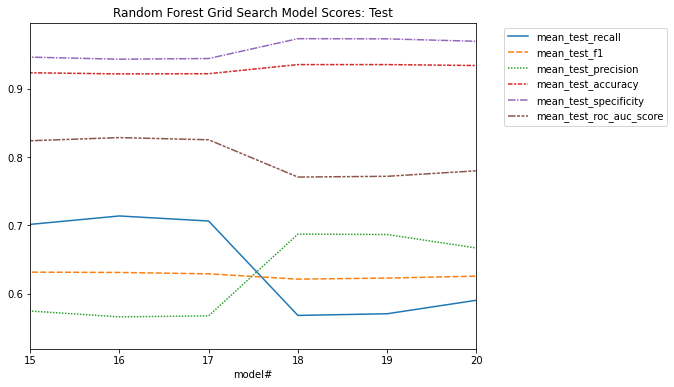

In [539]:
# Test Scoring Plot
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_fine_scores_test)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.xlim(0,20)
# plt.xticks(np.arange(0,21,1))
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Test')
plt.xlim(15,20)
plt.xticks(range(15,21,1))
# plt.savefig('../output/rf_grid_fine_scores_test1.png')

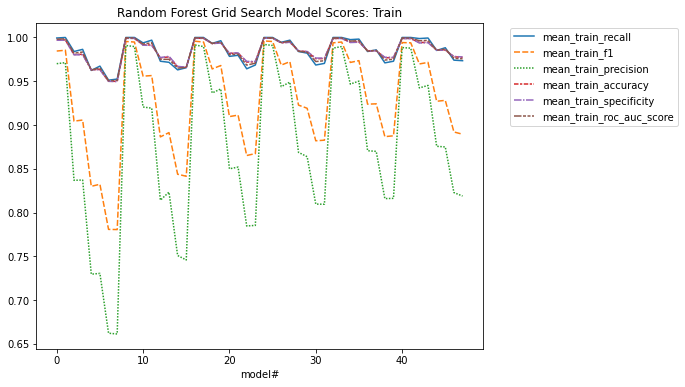

In [529]:
# Train Scoring Plot
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_train)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Train')
plt.savefig('../output/rf_grid_fine_scores_train1.png')

In [536]:
best_row = rf_grid_fine_scores.mean_test_recall.idxmax()
worst_row = rf_grid_fine_scores.mean_test_recall.idxmin()
print('best RF row number', best_row)
print('worst RF row number', worst_row)
print('best RF fine', rf_grid_fine_scores.params[best_row], '\n',
      'mean_test_f1', round(rf_grid_fine_scores.mean_test_f1[best_row], 4),
      'mean_test_recall', round(rf_grid_fine_scores.mean_test_recall[best_row], 4),
     'mean_test_specificity', round(rf_grid_fine_scores.mean_test_specificity[best_row], 4))

best RF row number 16
worst RF row number 54
best RF fine {'max_features': 1, 'min_samples_split': 14, 'n_estimators': 500} 
 mean_test_f1 0.6308 mean_test_recall 0.7136 mean_test_specificity 0.9432


In [531]:
rf_best_fine = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced', 
                                  max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=200)
rf_best_fine.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)

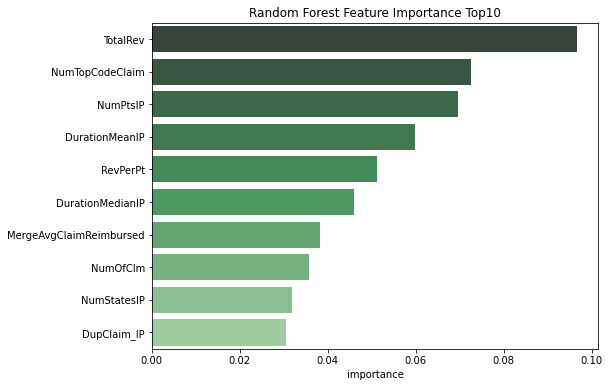

In [532]:
rf_feature_imp_fine = pd.DataFrame(data = rf_best_fine.feature_importances_, index=xtrain.columns, columns=['importance']).sort_values(by = 'importance', ascending=False)
# rf_feature_imp.plot(kind = 'bar')
rf_feature_imp_fine.to_csv('../output/rf_final_fine_features_importance.csv')
plt.figure(figsize=(8,6))
sns.barplot(y = rf_feature_imp_fine.index[:10], x = 'importance', data = rf_feature_imp_fine[:10],palette=sns.color_palette('Greens_d', n_colors=10))
plt.title('Random Forest Feature Importance Top10')
plt.savefig('../output/rf_final_fine_feature_importance.png')

In [ ]:
# sklearn.feature_selection import selectFromModel
# compute_class_weight

### K means clustering